In [2]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_excel('olive-oil-market-prices_en_1.xlsx', sheet_name = "Data").iloc[:, :13]

In [3]:
#df['ReferenceFrom'] = pd.to_numeric(df['ReferenceFrom'], errors='coerce')

#df_fecha_base = datetime(1899, 12, 30)

#df['ReferenceFrom'] = df_fecha_base + df['ReferenceFrom'].apply(lambda x: timedelta(days=x))

In [ ]:
#df['ReferenceTo'] = pd.to_numeric(df['ReferenceTo'], errors='coerce')

#df['ReferenceTo'] = df_fecha_base + df['ReferenceTo'].apply(lambda x: timedelta(days=x))

In [ ]:
df = df.drop(columns = ['Member State', 'Product', 'Category', 'Year', 'Month', 'Week', 'ReferenceTo'])

In [24]:
df

,MemberState,ReferenceFrom,Price,Market,Prod,MY
0,Croatia,2014-01-06,790.27,HRVATSKA,Extra virgin olive oil,2013/14
1,Croatia,2014-01-13,488.11,HRVATSKA,Extra virgin olive oil,2013/14
2,Croatia,2014-01-13,531.36,HRVATSKA,Virgin olive oil,2013/14
3,Croatia,2014-01-20,367.95,HRVATSKA,Extra virgin olive oil,2013/14
4,Croatia,2014-01-20,390.71,HRVATSKA,Virgin olive oil,2013/14
...,...,...,...,...,...,...
44615,Spain,2023-09-11,848.75,National,Extra virgin olive oil,2022/23
44616,Spain,2023-09-11,746.05,National,Lampante olive oil,2022/23
44617,Spain,2023-09-11,743.29,National,Refined olive oil,2022/23
44618,Spain,2023-09-11,308.76,National,Refined olive-pomace oil,2022/23


# **Lista de elementos a filtrar**


In [25]:
# Listas de elementos para filtrar

paises = df['MemberState'].unique()         # Por países

mercados = df['Market'].unique()            # Por producto

productos = df['Prod'].unique()             # Por mercado

In [26]:
def filtrar_pais(dataframe, pais):

    filtro_pais = dataframe[dataframe['MemberState'] == pais]
    return filtro_pais

# pais_filtrado = filtrar_pais(df, 'Spain')
# pais_filtrado.reset_index(drop = True)

def filtrar_mercado(dataframe, mercado):

    filtro_mercado = dataframe[dataframe['Market'] == mercado]
    return filtro_mercado

# mercado_filtrado = filtrar_mercado(df, 'Jaén')
# pais_filtrado.reset_index(drop = True)

def filtrar_producto(dataframe, producto):

    filtro_producto = dataframe[dataframe['Prod'] == producto]
    return filtro_producto

#def filtrar_rango_fechas(dataframe, fecha_inicio, fecha_fin):
#    return dataframe[(dataframe['ReferenceFrom'] >= fecha_inicio) & (dataframe['ReferenceFrom'] <= fecha_fin)]


# producto_filtrado = filtrar_producto(df, 'Virgin olive oil')
# producto_filtrado.reset_index(drop = True)

# *DFs Jaén Filtrados*

In [27]:
productos

array(['Extra virgin olive oil', 'Virgin olive oil', 'Lampante olive oil',
       'Crude olive-pomace oil', 'Refined olive oil', 'Olive-pomace oil',
       'Refined olive-pomace oil'], dtype=object)

In [28]:
resultados_por_producto = {}

for producto in productos:
    df_filtrado = filtrar_mercado(filtrar_producto(df, producto), 'Jaén')["Price"].values
    resultados_por_producto[producto] = df_filtrado

# **Modelo GRU lonja de Jaén AOVE**

In [29]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l1, l2
import tensorflow as tf

In [30]:
# Preparación de los datos
T = 5  # Segmentos
X = list()
y = list()

data = resultados_por_producto['Extra virgin olive oil']

for t in range(len(data) - T):
    x = data[t : t + T]
    X.append(x)
    y_ = data[t + T]
    y.append(y_)

# Transformamos a np.array y ajustamos las dimensiones
X = np.array(X).reshape(-1, T, 1)
y = np.array(y)
N = len(X)

print(f"X: {X.shape}\ty: {y.shape}")

X: (693, 5, 1)	y: (693,)


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Crear el modelo GRU
model = Sequential()
model.add(GRU(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
12/12 [==============================] - 2s 57ms/step - loss: 85586.2500 - val_loss: 79816.7578
Epoch 2/100
12/12 [==============================] - 0s 11ms/step - loss: 71423.9844 - val_loss: 69079.3984
Epoch 3/100
12/12 [==============================] - 0s 13ms/step - loss: 60891.4219 - val_loss: 57448.5039
Epoch 4/100
12/12 [==============================] - 0s 12ms/step - loss: 33411.7344 - val_loss: 8314.9854
Epoch 5/100
12/12 [==============================] - 0s 15ms/step - loss: 2628.7566 - val_loss: 272.1149
Epoch 6/100
12/12 [==============================] - 0s 14ms/step - loss: 779.9238 - val_loss: 366.5212
Epoch 7/100
12/12 [==============================] - 0s 13ms/step - loss: 207.9622 - val_loss: 110.9620
Epoch 8/100
12/12 [==============================] - 0s 15ms/step - loss: 150.2019 - val_loss: 115.0468
Epoch 9/100
12/12 [==============================] - 0s 13ms/step - loss: 116.1448 - val_loss: 73.2408
Epoch 10/100
12/12 [=============================

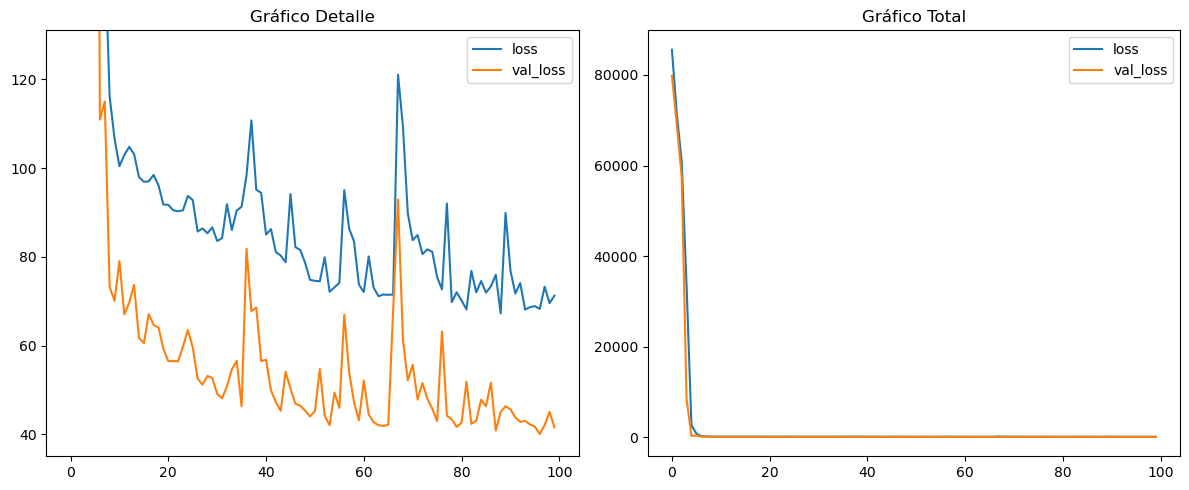

In [33]:
# Calcular los valores mínimos y máximos de val_loss con un margen para su mejor representación
min_loss = min(min(history.history["loss"][-25:]), min(history.history["val_loss"][-25:])) - 5
max_loss = max(max(history.history["loss"][-35:]), max(history.history["val_loss"][-35:])) + 10

# Crear una figura y ejes para cada gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primer gráfico (curva de pérdida y validación)
axs[0].plot(history.history["loss"], label="loss")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_ylim(min_loss, max_loss)  # Aplica los límites con margen
axs[0].legend()
axs[0].set_title('Gráfico Detalle')

# Segundo gráfico (curva de pérdida y validación)
axs[1].plot(history.history["loss"], label="loss")
axs[1].plot(history.history["val_loss"], label="val_loss")
axs[1].legend()
axs[1].set_title('Gráfico Total')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

5/5 [==============================] - 0s 3ms/step


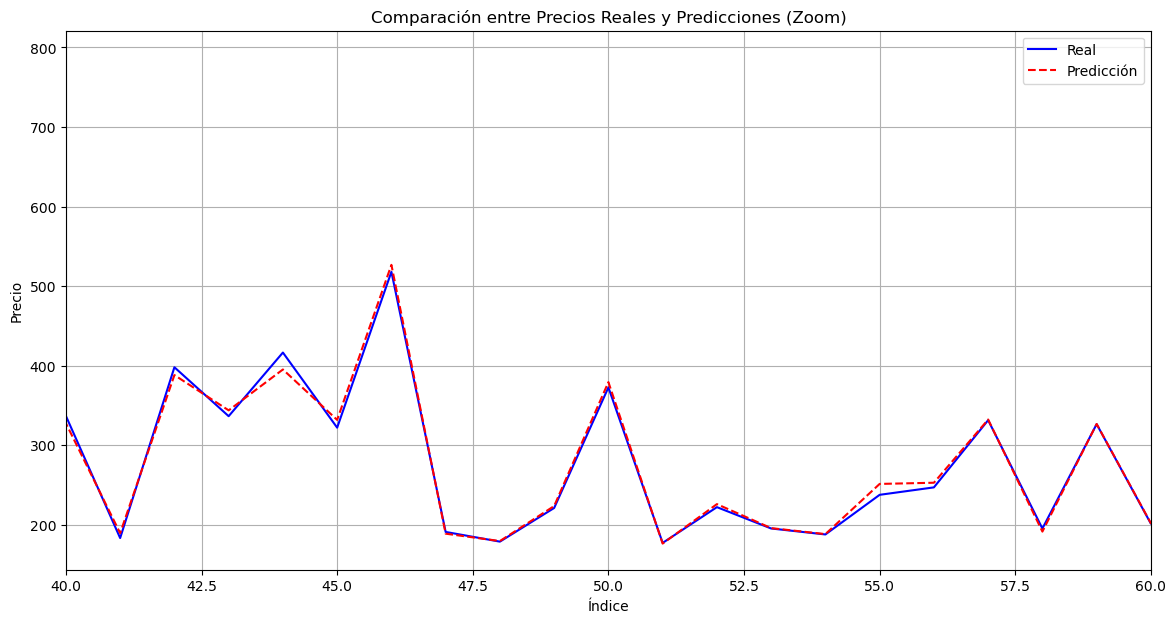

In [35]:
# Realiza predicciones con el modelo
y_pred = model.predict(X_test)

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Real', color='blue')
plt.plot(y_pred, label='Predicción', color='red', linestyle='--')

# Establecer límites para el eje x para hacer un zoom entre los índices 40 y 60
plt.xlim(40, 60)

plt.title('Comparación entre Precios Reales y Predicciones (Zoom)')
plt.ylabel('Precio')
plt.xlabel('Índice')
plt.legend()
plt.grid(True)
plt.show()


In [36]:
# Evaluación

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

5/5 [==============================] - 0s 3ms/step
Mean Squared Error: 41.55150712733022


# Modelo con LSTM lonja de Jaén AOVE

In [37]:
# Preparación de los datos
T = 5  # Segmentos
X = list()
y = list()

data = resultados_por_producto['Extra virgin olive oil']

for t in range(len(data) - T):
    x = data[t : t + T]
    X.append(x)
    y_ = data[t + T]
    y.append(y_)

# Transformamos a np.array y ajustamos las dimensiones
X = np.array(X).reshape(-1, T, 1)
y = np.array(y)
N = len(X)

print(f"X: {X.shape}\ty: {y.shape}")

X: (693, 5, 1)	y: (693,)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
12/12 [==============================] - 2s 36ms/step - loss: 90943.4453 - val_loss: 86237.6562
Epoch 2/100
12/12 [==============================] - 0s 13ms/step - loss: 78975.1484 - val_loss: 79492.9766
Epoch 3/100
12/12 [==============================] - 0s 14ms/step - loss: 60782.8750 - val_loss: 36581.6484
Epoch 4/100
12/12 [==============================] - 0s 13ms/step - loss: 7054.2627 - val_loss: 828.3472
Epoch 5/100
12/12 [==============================] - 0s 14ms/step - loss: 584.8436 - val_loss: 398.6762
Epoch 6/100
12/12 [==============================] - 0s 13ms/step - loss: 339.2536 - val_loss: 299.6745
Epoch 7/100
12/12 [==============================] - 0s 13ms/step - loss: 281.6318 - val_loss: 266.8675
Epoch 8/100
12/12 [==============================] - 0s 12ms/step - loss: 226.7367 - val_loss: 186.7359
Epoch 9/100
12/12 [==============================] - 0s 12ms/step - loss: 179.0649 - val_loss: 144.2735
Epoch 10/100
12/12 [==============================]

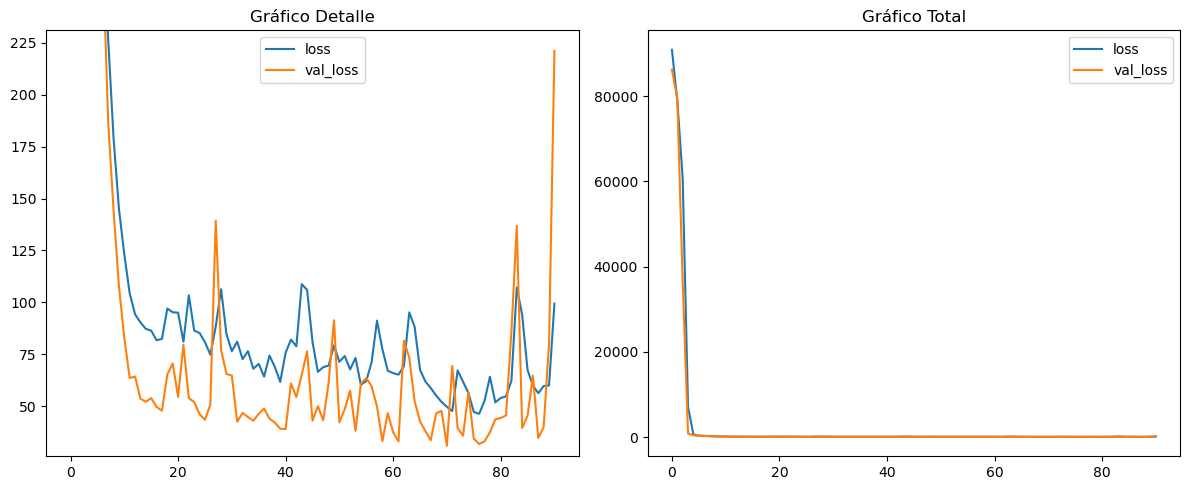

In [40]:
# Calcular los valores mínimos y máximos de val_loss con un margen para su mejor representación
min_loss = min(min(history.history["loss"][-25:]), min(history.history["val_loss"][-25:])) - 5
max_loss = max(max(history.history["loss"][-35:]), max(history.history["val_loss"][-35:])) + 10

# Crear una figura y ejes para cada gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primer gráfico (curva de pérdida y validación)
axs[0].plot(history.history["loss"], label="loss")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_ylim(min_loss, max_loss)  # Aplica los límites con margen
axs[0].legend()
axs[0].set_title('Gráfico Detalle')

# Segundo gráfico (curva de pérdida y validación)
axs[1].plot(history.history["loss"], label="loss")
axs[1].plot(history.history["val_loss"], label="val_loss")
axs[1].legend()
axs[1].set_title('Gráfico Total')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

5/5 [==============================] - 0s 4ms/step


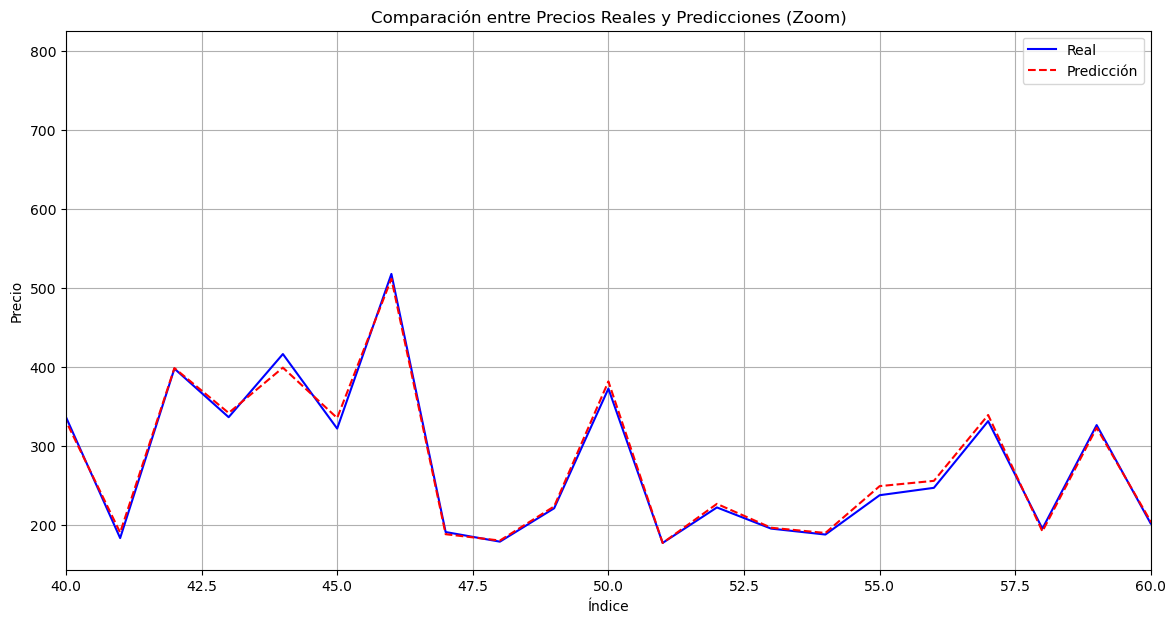

In [41]:
# Realiza predicciones con el modelo
y_pred = model.predict(X_test)

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Real', color='blue')
plt.plot(y_pred, label='Predicción', color='red', linestyle='--')

# Establecer límites para el eje x para hacer un zoom entre los índices 40 y 60
plt.xlim(40, 60)

plt.title('Comparación entre Precios Reales y Predicciones (Zoom)')
plt.ylabel('Precio')
plt.xlabel('Índice')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Evaluación

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

5/5 [==============================] - 0s 5ms/step
Mean Squared Error: 30.79075893579419


# Modelo con LSTM lonja de Jaén Lampante

In [43]:
# Preparación de los datos
T = 5  # Segmentos
X = list()
y = list()

data = resultados_por_producto['Lampante olive oil']

for t in range(len(data) - T):
    x = data[t : t + T]
    X.append(x)
    y_ = data[t + T]
    y.append(y_)

# Transformamos a np.array y ajustamos las dimensiones
X = np.array(X).reshape(-1, T, 1)
y = np.array(y)
N = len(X)

print(f"X: {X.shape}\ty: {y.shape}")

X: (693, 5, 1)	y: (693,)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
12/12 [==============================] - 2s 45ms/step - loss: 91890.3203 - val_loss: 90233.1250
Epoch 2/100
12/12 [==============================] - 0s 18ms/step - loss: 82700.5859 - val_loss: 83086.9609
Epoch 3/100
12/12 [==============================] - 0s 15ms/step - loss: 75197.3672 - val_loss: 74226.0234
Epoch 4/100
12/12 [==============================] - 0s 20ms/step - loss: 63532.4766 - val_loss: 57146.7383
Epoch 5/100
12/12 [==============================] - 0s 13ms/step - loss: 46164.8281 - val_loss: 6029.3608
Epoch 6/100
12/12 [==============================] - 0s 16ms/step - loss: 2086.8313 - val_loss: 430.1660
Epoch 7/100
12/12 [==============================] - 0s 14ms/step - loss: 283.5166 - val_loss: 124.0570
Epoch 8/100
12/12 [==============================] - 0s 16ms/step - loss: 92.7451 - val_loss: 66.3076
Epoch 9/100
12/12 [==============================] - 0s 16ms/step - loss: 50.7551 - val_loss: 35.8803
Epoch 10/100
12/12 [============================

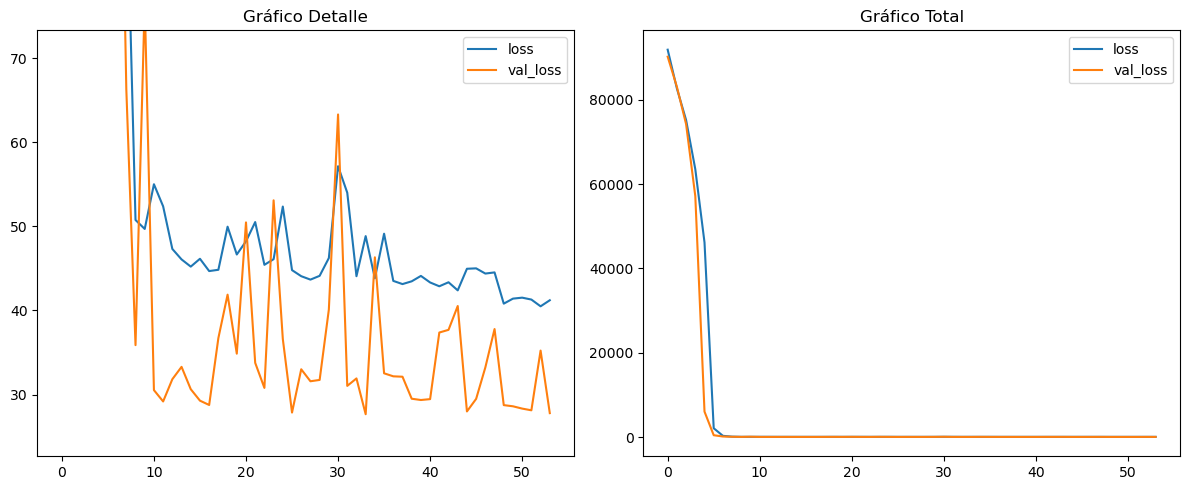

In [46]:
# Calcular los valores mínimos y máximos de val_loss con un margen para su mejor representación
min_loss = min(min(history.history["loss"][-25:]), min(history.history["val_loss"][-25:])) - 5
max_loss = max(max(history.history["loss"][-35:]), max(history.history["val_loss"][-35:])) + 10

# Crear una figura y ejes para cada gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primer gráfico (curva de pérdida y validación)
axs[0].plot(history.history["loss"], label="loss")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_ylim(min_loss, max_loss)  # Aplica los límites con margen
axs[0].legend()
axs[0].set_title('Gráfico Detalle')

# Segundo gráfico (curva de pérdida y validación)
axs[1].plot(history.history["loss"], label="loss")
axs[1].plot(history.history["val_loss"], label="val_loss")
axs[1].legend()
axs[1].set_title('Gráfico Total')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

5/5 [==============================] - 0s 2ms/step


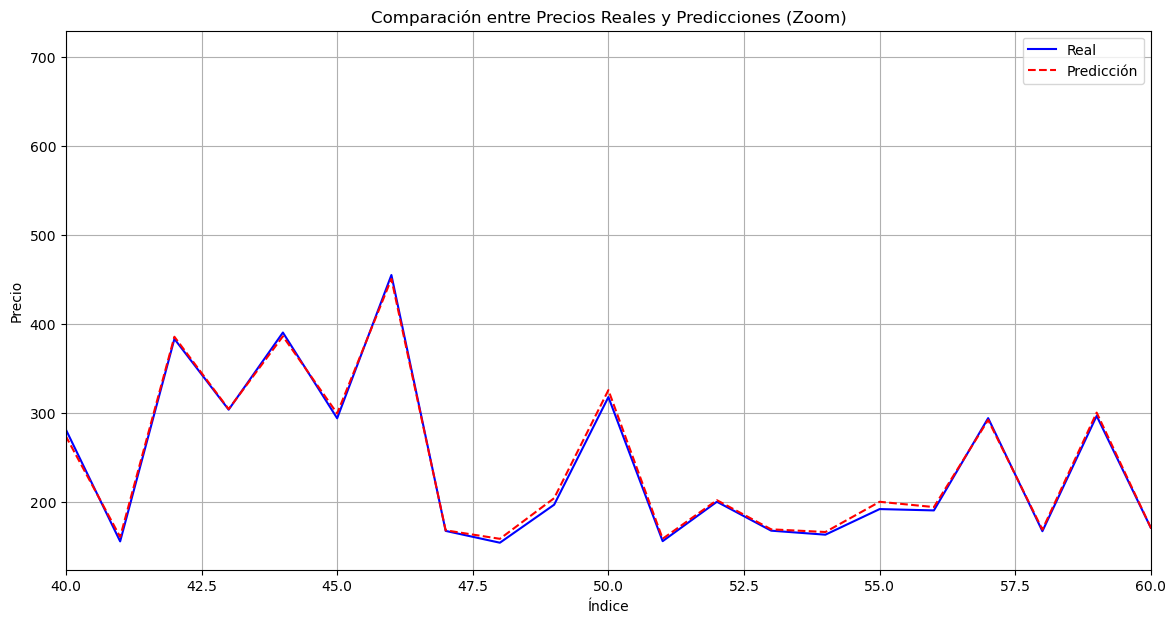

In [48]:
# Realiza predicciones con el modelo
y_pred = model.predict(X_test)

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Real', color='blue')
plt.plot(y_pred, label='Predicción', color='red', linestyle='--')

# Establecer límites para el eje x para hacer un zoom entre los índices 40 y 60
plt.xlim(40, 60)

plt.title('Comparación entre Precios Reales y Predicciones (Zoom)')
plt.ylabel('Precio')
plt.xlabel('Índice')
plt.legend()
plt.grid(True)
plt.show()

In [49]:
# Evaluación

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

5/5 [==============================] - 0s 3ms/step
Mean Squared Error: 27.670553053526092


# Modelo con LSTM lonja de Jaén Crude olive pomace oil

In [50]:
# Preparación de los datos
T = 5  # Segmentos
X = list()
y = list()

data = resultados_por_producto['Crude olive-pomace oil']

for t in range(len(data) - T):
    x = data[t : t + T]
    X.append(x)
    y_ = data[t + T]
    y.append(y_)

# Transformamos a np.array y ajustamos las dimensiones
X = np.array(X).reshape(-1, T, 1)
y = np.array(y)
N = len(X)

print(f"X: {X.shape}\ty: {y.shape}")

X: (692, 5, 1)	y: (692,)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
12/12 [==============================] - 3s 53ms/step - loss: 15001.0254 - val_loss: 14821.8701
Epoch 2/100
12/12 [==============================] - 0s 15ms/step - loss: 14278.3232 - val_loss: 14302.7783
Epoch 3/100
12/12 [==============================] - 0s 13ms/step - loss: 13866.7891 - val_loss: 13952.8926
Epoch 4/100
12/12 [==============================] - 0s 15ms/step - loss: 13496.6016 - val_loss: 13422.3271
Epoch 5/100
12/12 [==============================] - 0s 16ms/step - loss: 11275.0566 - val_loss: 589.3773
Epoch 6/100
12/12 [==============================] - 0s 18ms/step - loss: 841.4573 - val_loss: 115.5538
Epoch 7/100
12/12 [==============================] - 0s 22ms/step - loss: 200.1100 - val_loss: 83.3053
Epoch 8/100
12/12 [==============================] - 0s 20ms/step - loss: 68.5600 - val_loss: 28.6219
Epoch 9/100
12/12 [==============================] - 0s 14ms/step - loss: 36.9099 - val_loss: 20.0802
Epoch 10/100
12/12 [==============================]

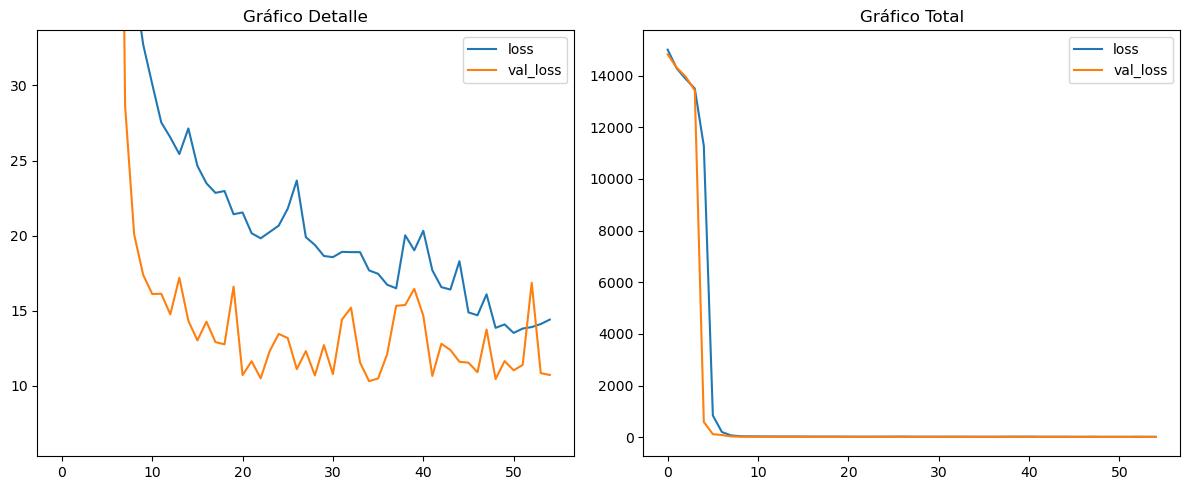

In [53]:
# Calcular los valores mínimos y máximos de val_loss con un margen para su mejor representación
min_loss = min(min(history.history["loss"][-25:]), min(history.history["val_loss"][-25:])) - 5
max_loss = max(max(history.history["loss"][-35:]), max(history.history["val_loss"][-35:])) + 10

# Crear una figura y ejes para cada gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primer gráfico (curva de pérdida y validación)
axs[0].plot(history.history["loss"], label="loss")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_ylim(min_loss, max_loss)  # Aplica los límites con margen
axs[0].legend()
axs[0].set_title('Gráfico Detalle')

# Segundo gráfico (curva de pérdida y validación)
axs[1].plot(history.history["loss"], label="loss")
axs[1].plot(history.history["val_loss"], label="val_loss")
axs[1].legend()
axs[1].set_title('Gráfico Total')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

5/5 [==============================] - 0s 3ms/step


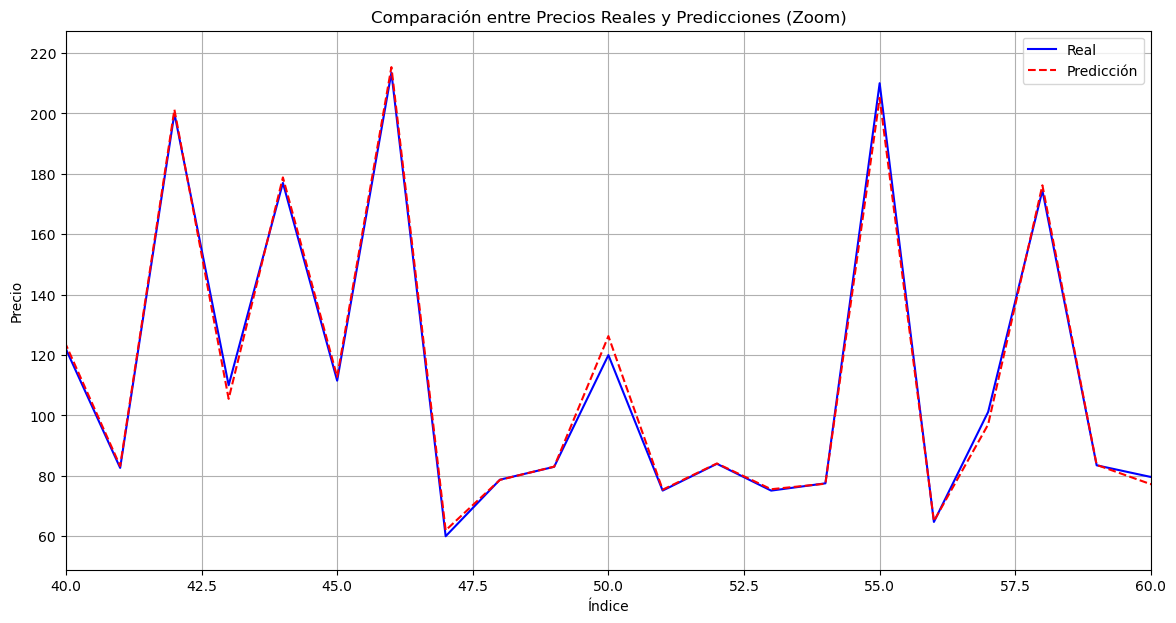

In [54]:
# Realiza predicciones con el modelo
y_pred = model.predict(X_test)

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Real', color='blue')
plt.plot(y_pred, label='Predicción', color='red', linestyle='--')

# Establecer límites para el eje x para hacer un zoom entre los índices 40 y 60
plt.xlim(40, 60)

plt.title('Comparación entre Precios Reales y Predicciones (Zoom)')
plt.ylabel('Precio')
plt.xlabel('Índice')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
# Evaluación

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

5/5 [==============================] - 0s 6ms/step
Mean Squared Error: 10.308200671524986


# Modelo con LSTM lonja de Jaén Refined olive oil

In [56]:
# Preparación de los datos
T = 5  # Segmentos
X = list()
y = list()

data = resultados_por_producto['Refined olive oil']

for t in range(len(data) - T):
    x = data[t : t + T]
    X.append(x)
    y_ = data[t + T]
    y.append(y_)

# Transformamos a np.array y ajustamos las dimensiones
X = np.array(X).reshape(-1, T, 1)
y = np.array(y)
N = len(X)

print(f"X: {X.shape}\ty: {y.shape}")

X: (693, 5, 1)	y: (693,)


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
12/12 [==============================] - 2s 33ms/step - loss: 55200.6719 - val_loss: 45981.5039
Epoch 2/100
12/12 [==============================] - 0s 12ms/step - loss: 33650.1406 - val_loss: 22287.2480
Epoch 3/100
12/12 [==============================] - 0s 12ms/step - loss: 9884.2812 - val_loss: 2530.3821
Epoch 4/100
12/12 [==============================] - 0s 14ms/step - loss: 1371.1353 - val_loss: 281.0523
Epoch 5/100
12/12 [==============================] - 0s 13ms/step - loss: 465.3853 - val_loss: 302.9024
Epoch 6/100
12/12 [==============================] - 0s 12ms/step - loss: 239.6739 - val_loss: 125.5485
Epoch 7/100
12/12 [==============================] - 0s 13ms/step - loss: 217.9284 - val_loss: 106.7424
Epoch 8/100
12/12 [==============================] - 0s 10ms/step - loss: 184.2681 - val_loss: 92.7316
Epoch 9/100
12/12 [==============================] - 0s 9ms/step - loss: 172.1502 - val_loss: 90.6257
Epoch 10/100
12/12 [==============================] - 0s

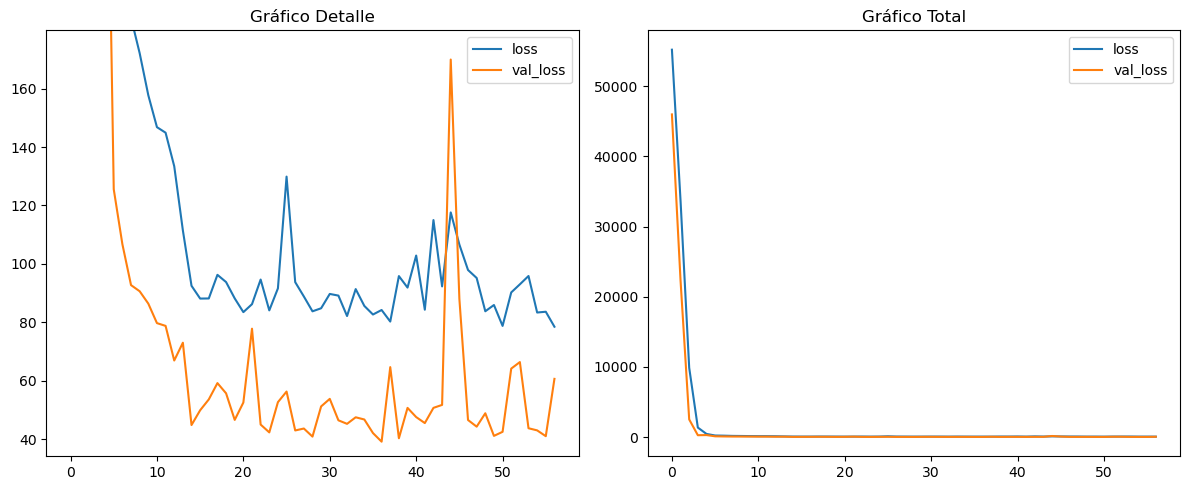

In [59]:
# Calcular los valores mínimos y máximos de val_loss con un margen para su mejor representación
min_loss = min(min(history.history["loss"][-25:]), min(history.history["val_loss"][-25:])) - 5
max_loss = max(max(history.history["loss"][-35:]), max(history.history["val_loss"][-35:])) + 10

# Crear una figura y ejes para cada gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primer gráfico (curva de pérdida y validación)
axs[0].plot(history.history["loss"], label="loss")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_ylim(min_loss, max_loss)  # Aplica los límites con margen
axs[0].legend()
axs[0].set_title('Gráfico Detalle')

# Segundo gráfico (curva de pérdida y validación)
axs[1].plot(history.history["loss"], label="loss")
axs[1].plot(history.history["val_loss"], label="val_loss")
axs[1].legend()
axs[1].set_title('Gráfico Total')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

5/5 [==============================] - 0s 3ms/step


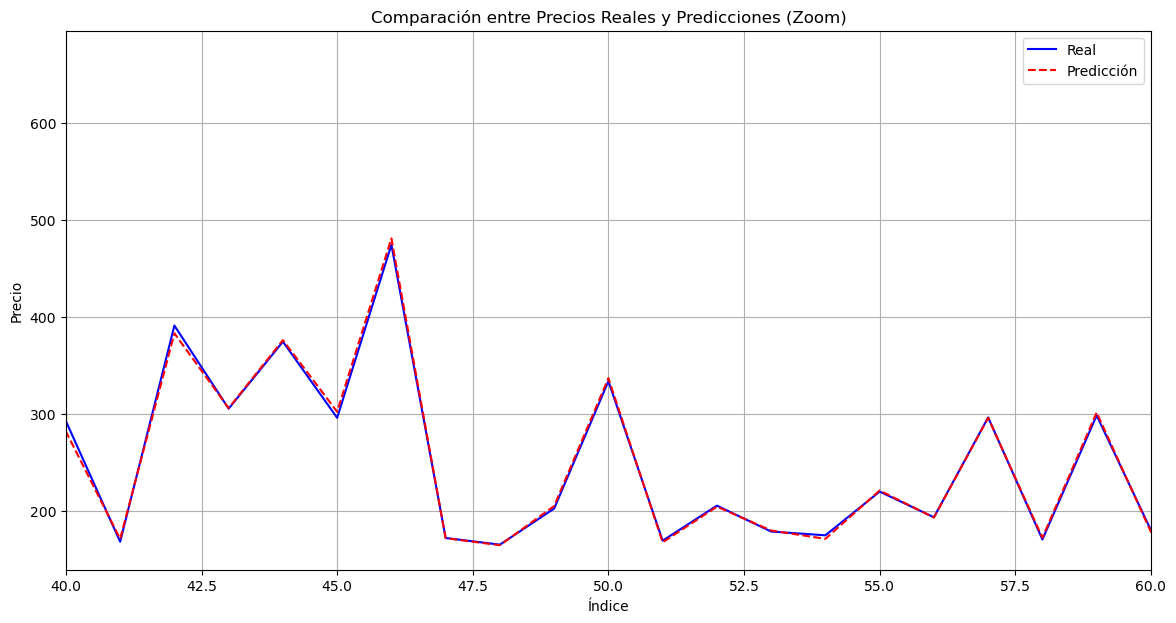

In [60]:
# Realiza predicciones con el modelo
y_pred = model.predict(X_test)

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Real', color='blue')
plt.plot(y_pred, label='Predicción', color='red', linestyle='--')

# Establecer límites para el eje x para hacer un zoom entre los índices 40 y 60
plt.xlim(40, 60)

plt.title('Comparación entre Precios Reales y Predicciones (Zoom)')
plt.ylabel('Precio')
plt.xlabel('Índice')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
# Evaluación

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

5/5 [==============================] - 0s 3ms/step
Mean Squared Error: 39.11779810688787


# Modelo con LSTM lonja de Jaén virgin olive oil

In [62]:
# Preparación de los datos
T = 5  # Segmentos
X = list()
y = list()

data = resultados_por_producto['Virgin olive oil']

for t in range(len(data) - T):
    x = data[t : t + T]
    X.append(x)
    y_ = data[t + T]
    y.append(y_)

# Transformamos a np.array y ajustamos las dimensiones
X = np.array(X).reshape(-1, T, 1)
y = np.array(y)
N = len(X)

print(f"X: {X.shape}\ty: {y.shape}")

X: (693, 5, 1)	y: (693,)


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [64]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
12/12 [==============================] - 2s 48ms/step - loss: 68802.4688 - val_loss: 56730.2344
Epoch 2/100
12/12 [==============================] - 0s 12ms/step - loss: 35864.3086 - val_loss: 10929.9590
Epoch 3/100
12/12 [==============================] - 0s 13ms/step - loss: 5610.8340 - val_loss: 508.9389
Epoch 4/100
12/12 [==============================] - 0s 11ms/step - loss: 324.1307 - val_loss: 493.5957
Epoch 5/100
12/12 [==============================] - 0s 11ms/step - loss: 457.4681 - val_loss: 170.2085
Epoch 6/100
12/12 [==============================] - 0s 11ms/step - loss: 205.2635 - val_loss: 162.8691
Epoch 7/100
12/12 [==============================] - 0s 10ms/step - loss: 211.9091 - val_loss: 121.5896
Epoch 8/100
12/12 [==============================] - 0s 13ms/step - loss: 159.5336 - val_loss: 88.6081
Epoch 9/100
12/12 [==============================] - 0s 13ms/step - loss: 147.0509 - val_loss: 90.2897
Epoch 10/100
12/12 [==============================] - 0s 

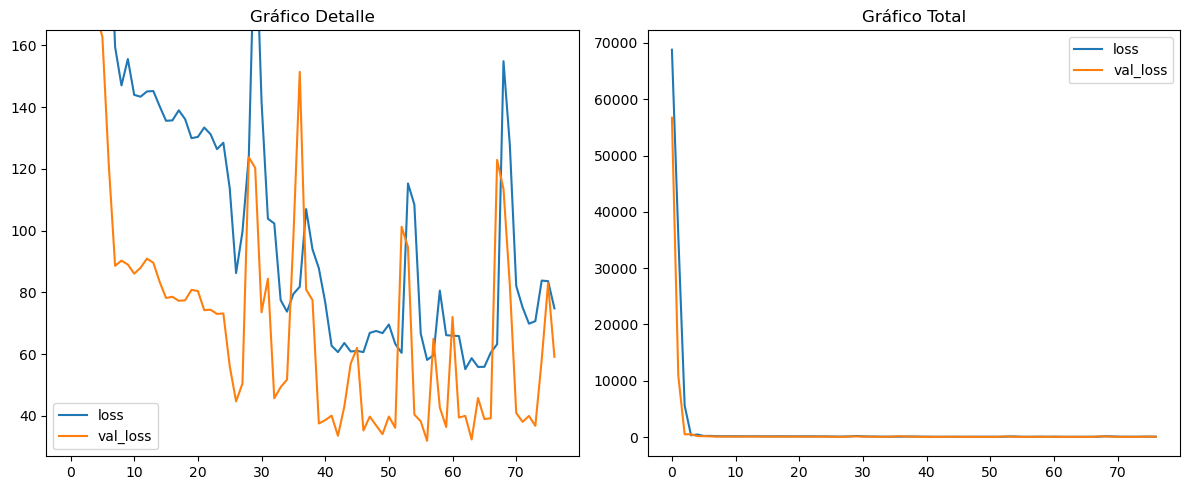

In [66]:
# Calcular los valores mínimos y máximos de val_loss con un margen para su mejor representación
min_loss = min(min(history.history["loss"][-25:]), min(history.history["val_loss"][-25:])) - 5
max_loss = max(max(history.history["loss"][-35:]), max(history.history["val_loss"][-35:])) + 10

# Crear una figura y ejes para cada gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primer gráfico (curva de pérdida y validación)
axs[0].plot(history.history["loss"], label="loss")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_ylim(min_loss, max_loss)  # Aplica los límites con margen
axs[0].legend()
axs[0].set_title('Gráfico Detalle')

# Segundo gráfico (curva de pérdida y validación)
axs[1].plot(history.history["loss"], label="loss")
axs[1].plot(history.history["val_loss"], label="val_loss")
axs[1].legend()
axs[1].set_title('Gráfico Total')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

5/5 [==============================] - 0s 5ms/step


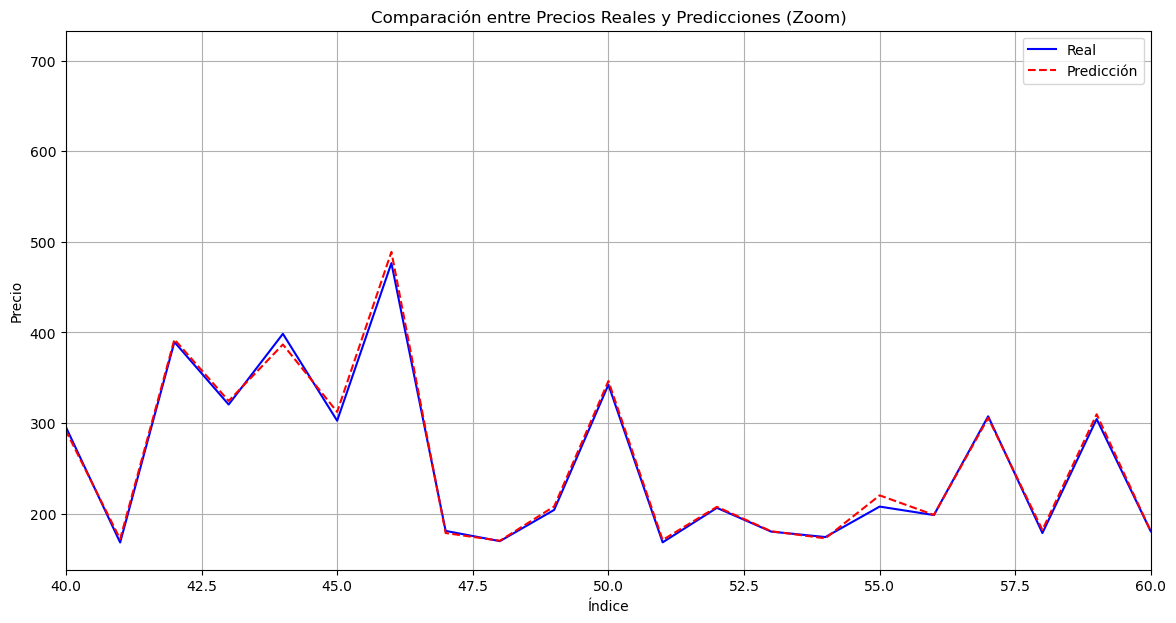

In [67]:
# Realiza predicciones con el modelo
y_pred = model.predict(X_test)

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Real', color='blue')
plt.plot(y_pred, label='Predicción', color='red', linestyle='--')

# Establecer límites para el eje x para hacer un zoom entre los índices 40 y 60
plt.xlim(40, 60)

plt.title('Comparación entre Precios Reales y Predicciones (Zoom)')
plt.ylabel('Precio')
plt.xlabel('Índice')
plt.legend()
plt.grid(True)
plt.show()

In [68]:
# Evaluación

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

5/5 [==============================] - 0s 6ms/step
Mean Squared Error: 31.889284395343036


# Modelo LSTM lonja Jaén AOVE hasta 2022

In [69]:
fecha_corte = pd.Timestamp('2022-01-01')
df_extra_olive_oil_jaen = filtrar_mercado(filtrar_producto(df, 'Extra virgin olive oil'), 'Jaén')

df_extra_olive_oil_jaen_2022 = df_extra_olive_oil_jaen[df_extra_olive_oil_jaen['ReferenceFrom'] < fecha_corte]
df_extra_olive_oil_jaen_2022

,MemberState,ReferenceFrom,Price,Market,Prod,MY
23112,Spain,2010-06-21,201.33,Jaén,Extra virgin olive oil,2009/10
23138,Spain,2010-06-28,198.33,Jaén,Extra virgin olive oil,2009/10
23169,Spain,2010-07-05,198.33,Jaén,Extra virgin olive oil,2009/10
23199,Spain,2010-07-12,198.32,Jaén,Extra virgin olive oil,2009/10
23228,Spain,2010-07-19,196.83,Jaén,Extra virgin olive oil,2009/10
...,...,...,...,...,...,...
41617,Spain,2021-11-22,314.50,Jaén,Extra virgin olive oil,2021/22
41644,Spain,2021-12-06,327.50,Jaén,Extra virgin olive oil,2021/22
41680,Spain,2021-12-13,326.50,Jaén,Extra virgin olive oil,2021/22
41711,Spain,2021-12-20,330.00,Jaén,Extra virgin olive oil,2021/22


In [70]:
# Preparación de los datos
T = 5  # Segmentos
X = list()
y = list()

data = df_extra_olive_oil_jaen_2022["Price"].values

for t in range(len(data) - T):
    x = data[t : t + T]
    X.append(x)
    y_ = data[t + T]
    y.append(y_)

# Transformamos a np.array y ajustamos las dimensiones
X = np.array(X).reshape(-1, T, 1)
y = np.array(y)
N = len(X)

print(f"X: {X.shape}\ty: {y.shape}")

X: (604, 5, 1)	y: (604,)


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar el modelo
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, batch_size=50, validation_data=(X_test, y_test), verbose=1, callbacks=[early_stop])

Epoch 1/100
10/10 [==============================] - 2s 44ms/step - loss: 41778.0508 - val_loss: 35898.7109
Epoch 2/100
10/10 [==============================] - 0s 14ms/step - loss: 25440.9531 - val_loss: 15798.6992
Epoch 3/100
10/10 [==============================] - 0s 14ms/step - loss: 8876.5830 - val_loss: 979.4174
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 339.6624 - val_loss: 275.6712
Epoch 5/100
10/10 [==============================] - 0s 10ms/step - loss: 166.3080 - val_loss: 154.1782
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 102.9087 - val_loss: 129.1286
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 93.6483 - val_loss: 111.4497
Epoch 8/100
10/10 [==============================] - 0s 16ms/step - loss: 78.0139 - val_loss: 103.9037
Epoch 9/100
10/10 [==============================] - 0s 13ms/step - loss: 69.1651 - val_loss: 90.4991
Epoch 10/100
10/10 [==============================] - 0s 11

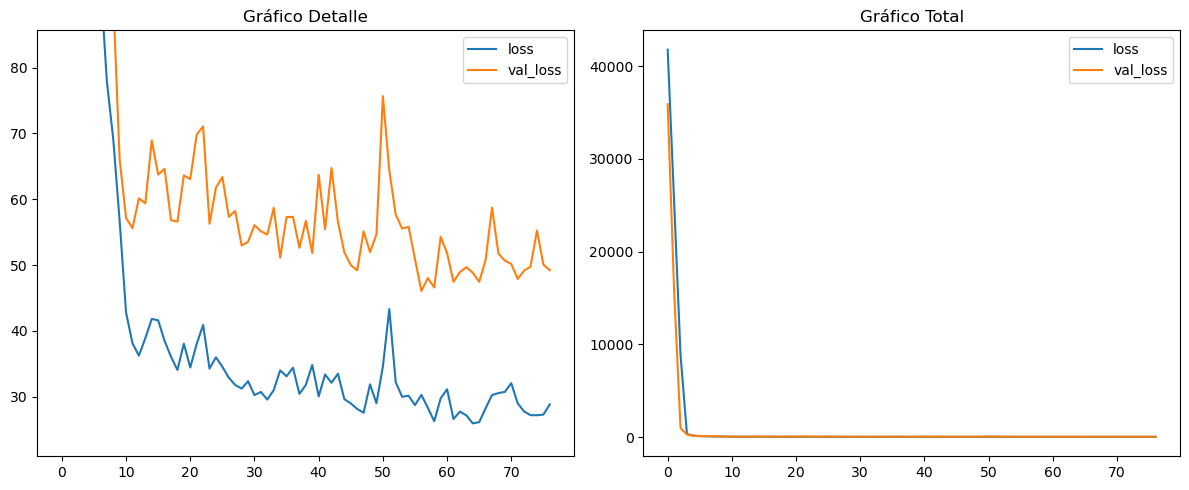

In [73]:
# Calcular los valores mínimos y máximos de val_loss con un margen para su mejor representación
min_loss = min(min(history.history["loss"][-25:]), min(history.history["val_loss"][-25:])) - 5
max_loss = max(max(history.history["loss"][-35:]), max(history.history["val_loss"][-35:])) + 10

# Crear una figura y ejes para cada gráfico
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Primer gráfico (curva de pérdida y validación)
axs[0].plot(history.history["loss"], label="loss")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_ylim(min_loss, max_loss)  # Aplica los límites con margen
axs[0].legend()
axs[0].set_title('Gráfico Detalle')

# Segundo gráfico (curva de pérdida y validación)
axs[1].plot(history.history["loss"], label="loss")
axs[1].plot(history.history["val_loss"], label="val_loss")
axs[1].legend()
axs[1].set_title('Gráfico Total')

# Mostrar los gráficos
plt.tight_layout()
plt.show()

4/4 [==============================] - 0s 5ms/step


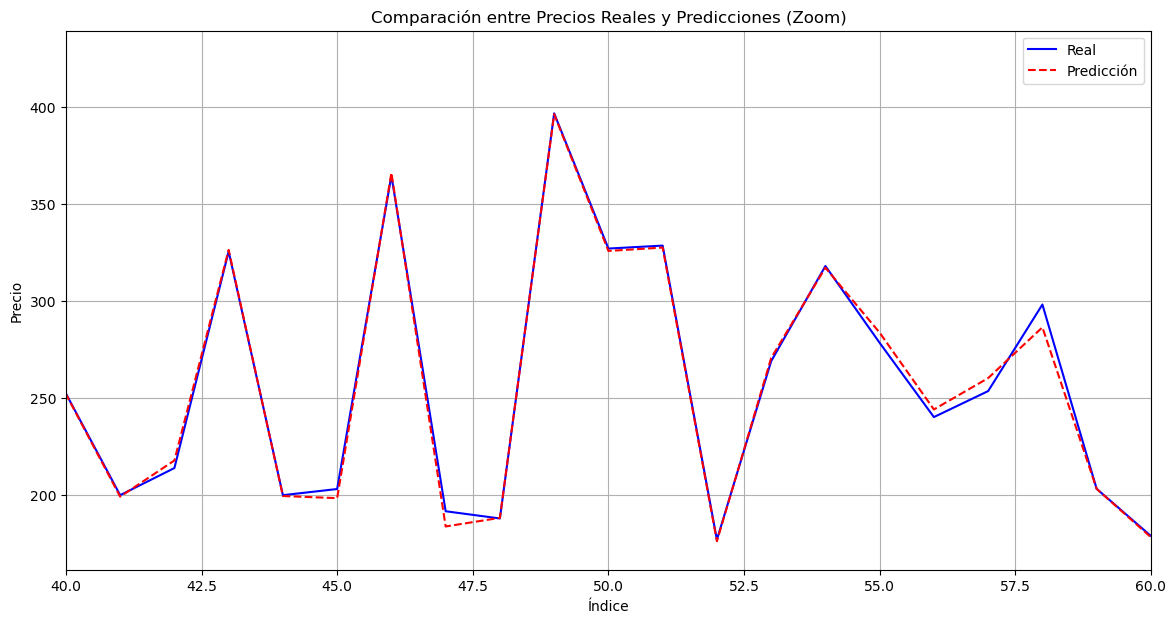

In [74]:
# Realiza predicciones con el modelo
y_pred = model.predict(X_test)

# Crear el gráfico
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Real', color='blue')
plt.plot(y_pred, label='Predicción', color='red', linestyle='--')

# Establecer límites para el eje x para hacer un zoom entre los índices 40 y 60
plt.xlim(40, 60)

plt.title('Comparación entre Precios Reales y Predicciones (Zoom)')
plt.ylabel('Precio')
plt.xlabel('Índice')
plt.legend()
plt.grid(True)
plt.show()

In [75]:
# Evaluación

predictions = model.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

4/4 [==============================] - 0s 5ms/step
Mean Squared Error: 46.0598791433183
